In [2]:
import pandas as pd
#Gráficos
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

#Modelo
import sklearn
import seaborn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import joblib
import yaml
import os

#Metricas
from sklearn.metrics import accuracy_score, classification_report

In [3]:
data = pd.read_csv('../data/train_test/anxiety_train.csv')

In [4]:
X = data.drop(columns='Anxiety_Group')

y = data['Anxiety_Group']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=55)

In [6]:
rf = RandomForestClassifier(
    random_state=42,
    n_estimators= 1000,
)

In [7]:
rf.fit(X_train, y_train)

,n_estimators,1000
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [8]:
pred_log = rf.predict(X_test)
acc_log = accuracy_score(y_test, pred_log)

In [9]:
print("Accuracy Random Forest:", acc_log)

Accuracy Random Forest: 0.9549414238510063


In [10]:
print("\nReporte de clasificación:")
print(classification_report(y_test, pred_log))


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.93      0.98      0.96      1684
           1       0.98      0.92      0.95      1645

    accuracy                           0.95      3329
   macro avg       0.96      0.95      0.95      3329
weighted avg       0.96      0.95      0.95      3329



In [11]:
cm = confusion_matrix(y_test, pred_log)

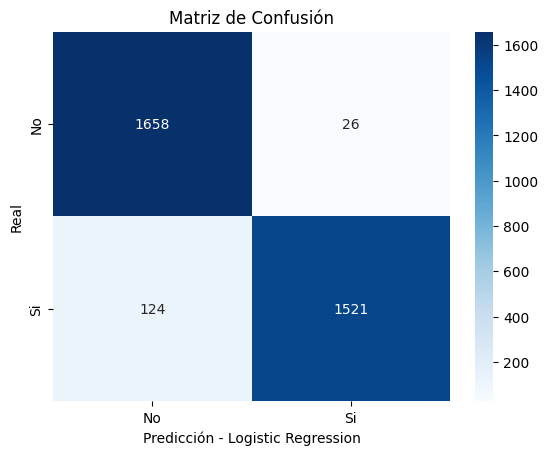

In [12]:
#from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred_log)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["No","Si"],
            yticklabels=["No","Si"])
plt.title("Matriz de Confusión")
plt.xlabel("Predicción - Logistic Regression")
plt.ylabel("Real")
plt.show()

Grid Search

In [23]:
param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

In [38]:
grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=7,
    scoring='balanced_accuracy',  
    n_jobs=-1,
    verbose=2
)

In [39]:
grid.fit(X_train, y_train)

Fitting 7 folds for each of 16 candidates, totalling 112 fits


,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'max_depth': [None], 'max_features': ['sqrt', 'log2'], 'min_samples_leaf': [1, 2], 'min_samples_split': [2, 5], ...}"
,scoring,'balanced_accuracy'
,n_jobs,-1
,refit,True
,cv,7
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,300


In [40]:
pred = grid.predict(X_test)

In [36]:
best_model = grid.best_estimator_
best_params = grid.best_params_

In [41]:
print("Mejor accuracy CV:", grid.best_score_)
print("Mejores parámetros:", grid.best_params_)

Mejor accuracy CV: 0.9556836610737397
Mejores parámetros: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [42]:
results = pd.DataFrame(grid.cv_results_)
resultados = results[[
    'param_n_estimators',
    'mean_test_score', 
    'std_test_score',
    'rank_test_score']]

In [43]:
pivot = results.pivot_table(
    index='param_n_estimators',
    columns='param_max_depth',
    values='mean_test_score'
)

In [44]:
'''pivot.plot(marker='o')
plt.title("Accuracy medio vs n_estimators (según max_depth)")
plt.xlabel("n_estimators")
plt.ylabel("Mean CV Accuracy")
plt.legend(title="max_depth")
plt.show()
'''

'pivot.plot(marker=\'o\')\nplt.title("Accuracy medio vs n_estimators (según max_depth)")\nplt.xlabel("n_estimators")\nplt.ylabel("Mean CV Accuracy")\nplt.legend(title="max_depth")\nplt.show()\n'

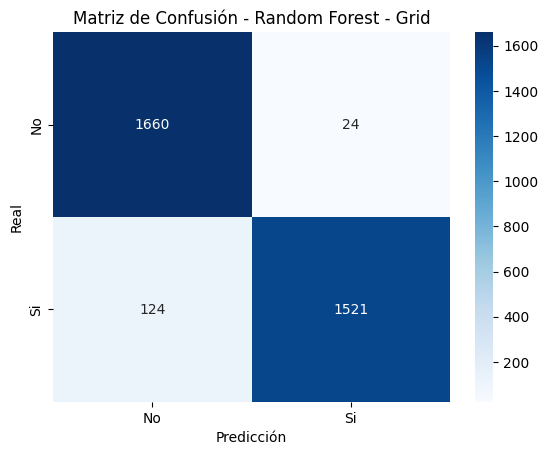

In [45]:
cm = confusion_matrix(y_test, pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No', 'Si'],
            yticklabels=['No', 'Si'])
plt.title("Matriz de Confusión - Random Forest - Grid")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

In [46]:
models = '../models'

In [47]:
final_model_path = os.path.join(models, 'final_model.pkl')
joblib.dump(best_model, final_model_path)
print(f"Modelo final guardado en: {final_model_path}")

Modelo final guardado en: ../models\final_model.pkl


In [48]:
config_path = os.path.join(models, 'model_config.yaml')

model_config = {
    'model_metadata': {
        'model_type': 'RandomForestClassifier',
        'best_score_cv': float(grid.best_score_), # Conversión a float nativo
        'hyperparameters': grid.best_params_
    },
    'dependencies': {
        'pandas': pd.__version__,
        'scikit-learn': sklearn.__version__,
        'seaborn': seaborn.__version__,
        'yaml_version': yaml.__version__
    }
}

with open(config_path, 'w') as file:
    yaml.dump(model_config, file, default_flow_style=False)

print(f"Configuración y versiones guardadas con éxito en: {config_path}")

Configuración y versiones guardadas con éxito en: ../models\model_config.yaml
